In [ ]:
%load_ext autoreload

In [ ]:
"Figure 9. Table 1."

In [2]:
import numpy as np
import pickle
from scipy.signal import butter, filtfilt

from basicOperations.manifoldOperations import matrixDistance, frechetMean, tangentMap

In [3]:
numberSubjects = 91
numberChannels = 12
numberGestures = 10
trialsPerGesture = 36

In [4]:
collateData = []
Frequency = []

for subjectNumber in range(1, 100):
    if subjectNumber not in [5, 11, 14, 17, 18, 35, 38, 41]:
        name = "../formattedData/" + str(subjectNumber) + ".pkl"
        with open(name, "rb") as file:
            loadedData = pickle.load(file)

        Features = loadedData["EMG"]
        normalizedFeatures = Features
        Labels = loadedData["Labels"]
        samples = 2 * loadedData["Frequency"]

        Indices =  {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
        for i in range(len(Labels)):
            Indices[Labels[i]].append(i)

        gesturesLabels = np.zeros((numberGestures, trialsPerGesture, numberChannels, 4000))
        for i in range(10):
            for j in range(36):
                gesturesLabels[i, j] = normalizedFeatures[Indices[i][j], :, :4000]
                
        collateData.append(gesturesLabels)
        Frequency.append(loadedData["Frequency"])

In [5]:
collateData = np.array(collateData)
Frequency = np.array(Frequency)
print(collateData.shape)
print(Frequency.shape)

(91, 10, 36, 12, 4000)
(91,)


In [6]:
geodesicDistance = matrixDistance()
manifoldMean = frechetMean()
logMap = tangentMap()

In [7]:
def butterworthBandpass(lowcut, highcut, fs, order = 3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype = 'band')
    return b, a

def applyBandpassFilter(data, lowcut, highcut, fs, order = 3):
    b, a = butterworthBandpass(lowcut, highcut, fs, order = order)
    filteredData = filtfilt(b, a, data, axis = -1)
    return filteredData

In [8]:
frequencies = np.array([[20, 50], [50, 110], [110, 230], [230, 450], [20, 450]])
filteredData = np.zeros((5, numberSubjects, numberGestures, trialsPerGesture, numberChannels, 4000))
for i in range(len(frequencies)):
    print(i)
    for subject in range(numberSubjects):
        filteredData[i, subject] = applyBandpassFilter(collateData[subject], frequencies[i, 0], frequencies[i, 1], Frequency[subject]) 

0
1
2
3
4


In [9]:
mean = np.mean(filteredData, axis = -1)
std = np.std(filteredData, axis = -1)
normalizedFilteredData = (filteredData - mean[..., np.newaxis])/std[..., np.newaxis]

In [10]:
covarianceMatrices = np.zeros((5, numberSubjects, numberGestures, trialsPerGesture, numberChannels, numberChannels))

In [11]:
for f in range(5):
    for subject in range(numberSubjects):
        for gesture in range(numberGestures):
            for repitition in range(trialsPerGesture):
                covarianceMatrices[f, subject, gesture, repitition] = 1/4000 * (normalizedFilteredData[f, subject, gesture, repitition, :, :] @ np.transpose(normalizedFilteredData[f, subject, gesture, repitition, :, :]))

In [12]:
trainCentroid = np.zeros((5, numberSubjects, numberGestures, numberChannels, numberChannels))

for band in range(5):
    for subject in range(numberSubjects):
        for i in range(numberGestures):
            trainCentroid[band, subject, i, :, :] = manifoldMean.mean(covarianceMatrices[band, subject, i, :18, :, :])

testFeatures = np.zeros((5, numberSubjects, 180, numberChannels, numberChannels))
testLabels = np.zeros((5, numberSubjects, 180))

for band in range(5):
    for subject in range(numberSubjects):
        count = 0
        for i in range(numberGestures):
            testFeatures[band, subject, count:count + 18] = covarianceMatrices[band, subject, i, 18:, :, :]
            testLabels[band, subject, count:count + 18] = [i] * 18
            count += 18

predictLabels = np.zeros((5, numberSubjects, 180))

for band in range(5):
    for subject in range(numberSubjects):
        for k in range(180):
            distances = np.zeros((numberGestures))
            for m in range(numberGestures):
                distances[m] = geodesicDistance.distance(testFeatures[band, subject, k], trainCentroid[band, subject, m])
            predictLabels[band, subject, k] = np.argmin(distances)

corrects = np.zeros((5, numberSubjects))

for band in range(5):
    for subject in range(numberSubjects):
        correct = np.mean((predictLabels[band, subject] == testLabels[band, subject]))
        corrects[band, subject] = correct

In [13]:
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fontPath = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf'
fontProp = font_manager.FontProperties(fname = fontPath)

font_manager.fontManager.addfont(fontPath)
mpl.rcParams['font.family'] = fontProp.get_name()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


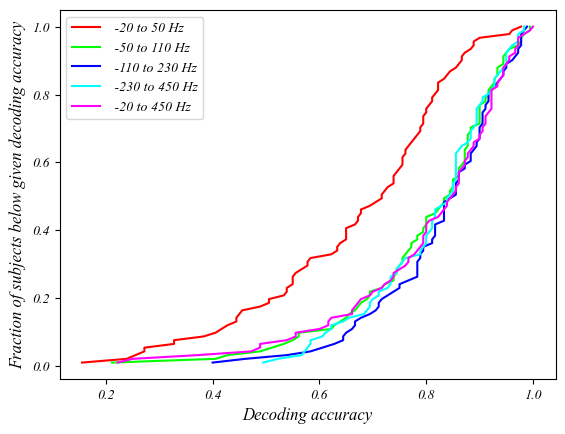

In [14]:
colors = ['#FF0000', '#00FF00', '#0000FF', '#00FFFF', '#FF00FF', '#FFA500', '#800080', '#A52A2A', '#FFC0CB']

tags = [" -20 to 50 Hz", " -50 to 110 Hz", " -110 to 230 Hz", " -230 to 450 Hz", " -20 to 450 Hz"]

for i in range(5):
    plt.plot(np.sort(corrects[i]), np.arange(1,  92)/91, label = tags[i], color = colors[i])

plt.xlabel('Decoding accuracy', fontproperties = fontProp, fontsize = 12)
plt.ylabel('Fraction of subjects below given decoding accuracy', fontproperties = fontProp, fontsize = 12)
plt.legend(loc = 'upper left')
plt.savefig("decodingAccuracyFrequencies.eps", format = "eps", bbox_inches = 'tight')
plt.show()
plt.close()

In [15]:
print(corrects.shape)
print(np.mean(corrects, axis = 1))

(5, 91)
[0.66862027 0.79884005 0.82478632 0.81098901 0.80140415]
